In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/weather-australia/weatherAUS.csv


# WITHOUT FEATURE SELECTION

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
903/903 ━━━━━━━━━━━━━━━━━━━━ 17s 10ms/step - accuracy: 0.7685 - loss: 2.1120 - learning_rate: 5.0000e-04
Epoch 2/50
903/903 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.8160 - loss: 0.4481 - learning_rate: 5.0000e-04
Epoch 3/50
903/903 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.8596 - loss: 0.3634 - learning_rate: 5.0000e-04
Epoch 4/50
903/903 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.8716 - loss: 0.3278 - learning_rate: 5.0000e-04
Epoch 5/50
903/903 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.8791 - loss: 0.3050 - learning_rate: 5.0000e-04
Epoch 6/50
903/903 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.8825 - loss: 0.2968 - learning_rate: 5.0000e-04
Epoch 7/50
903/903 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.8871 - loss: 0.2938 - learning_rate: 5.0000e-04
Epoch 8/50
903/903 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.8873 - loss: 0.2890 - learning_rate: 5.0000e-04
Epoch 9/50
903/903 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.8913 - loss:

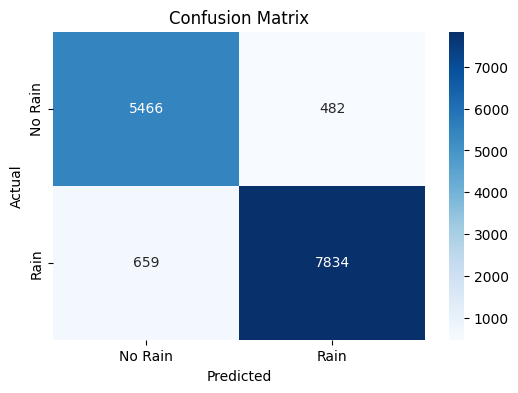

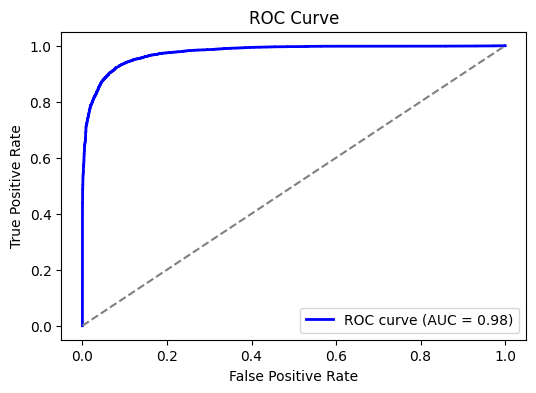

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.combine import SMOTEENN
from imblearn.metrics import geometric_mean_score

# Load dataset
df = pd.read_csv("/kaggle/input/weather-australia/weatherAUS.csv")
# Drop unnecessary columns
df.drop(['Date', 'Location'], axis=1, inplace=True)
# Convert categorical features to numeric
df['RainToday'] = df['RainToday'].map({'No': 0, 'Yes': 1})
df['RainTomorrow'] = df['RainTomorrow'].map({'No': 0, 'Yes': 1})

# Encode wind direction features using Label Encoding
categorical_cols = ['WindGustDir', 'WindDir9am', 'WindDir3pm']
le = LabelEncoder()
for col in categorical_cols:
    df[col] = le.fit_transform(df[col].astype(str))
# Remove rows with missing values
df.dropna(inplace=True)

# Split into features & target
X = df.drop(['RainTomorrow'], axis=1)
y = df['RainTomorrow']
# Balance classes using SMOTE+ENN
smote_enn = SMOTEENN(random_state=42)
X_resampled, y_resampled = smote_enn.fit_resample(X, y)
# Stratified K-Fold Validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
train_idx, test_idx = next(skf.split(X_resampled, y_resampled))
X_train, X_test = X_resampled.iloc[train_idx], X_resampled.iloc[test_idx]
y_train, y_test = y_resampled[train_idx], y_resampled[test_idx]
# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape for LSTM
X_train_LSTM = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_LSTM = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))
# LSTM Model
lstm_model = Sequential([
    Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer=l2(0.01))),
    BatchNormalization(),
    Dropout(0.4),
    Bidirectional(LSTM(64, return_sequences=False, kernel_regularizer=l2(0.01))),
    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.4),
    Dense(1, activation='sigmoid')
])
lstm_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy'])
# ANN Model
ann_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],), kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.4),
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.4),
    Dense(1, activation='sigmoid')
])
ann_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
callbacks = [
    ReduceLROnPlateau(monitor='loss', factor=0.5, patience=3, verbose=1),
    EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
]
# Train LSTM
lstm_model.fit(X_train_LSTM, y_train, epochs=50, batch_size=64, verbose=1, callbacks=callbacks)
lstm_preds_train = lstm_model.predict(X_train_LSTM)
lstm_preds_test = lstm_model.predict(X_test_LSTM)
# Train ANN
ann_model.fit(X_train_scaled, y_train, epochs=50, batch_size=64, verbose=1, callbacks=callbacks)
ann_preds_train = ann_model.predict(X_train_scaled)
ann_preds_test = ann_model.predict(X_test_scaled)

# Stacking (Meta-Model using SVM instead of Logistic Regression)
X_meta_train = np.column_stack((lstm_preds_train, ann_preds_train))
X_meta_test = np.column_stack((lstm_preds_test, ann_preds_test))
meta_model = SVC(kernel='linear', probability=True)
meta_model.fit(X_meta_train, y_train)
# Get Final Predictions
meta_probs = meta_model.predict_proba(X_meta_test)[:, 1]
final_preds = (meta_probs > 0.5).astype(int)

# Evaluation Metrics
accuracy = accuracy_score(y_test, final_preds)
precision = precision_score(y_test, final_preds)
recall = recall_score(y_test, final_preds)
f1 = f1_score(y_test, final_preds)
g_mean = geometric_mean_score(y_test, final_preds)
print(f"✅ Accuracy: {accuracy:.4f}")
print(f"✅ Precision: {precision:.4f}")
print(f"✅ Recall: {recall:.4f}")
print(f"✅ F1-Score: {f1:.4f}")
print(f"✅ G-Mean: {g_mean:.4f}")
# Confusion Matrix
cm = confusion_matrix(y_test, final_preds)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['No Rain', 'Rain'], yticklabels=['No Rain', 'Rain'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, meta_probs)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


# WITH FEATURE SELECTION

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


903/903 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 0.7816 - loss: 2.7415 - learning_rate: 5.0000e-04
Epoch 2/50
903/903 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - accuracy: 0.8531 - loss: 0.4025 - learning_rate: 5.0000e-04
Epoch 3/50
903/903 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - accuracy: 0.8788 - loss: 0.3258 - learning_rate: 5.0000e-04
Epoch 4/50
903/903 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - accuracy: 0.8805 - loss: 0.3115 - learning_rate: 5.0000e-04
Epoch 5/50
903/903 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - accuracy: 0.8893 - loss: 0.2954 - learning_rate: 5.0000e-04
Epoch 6/50
903/903 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - accuracy: 0.8901 - loss: 0.2920 - learning_rate: 5.0000e-04
Epoch 7/50
903/903 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - accuracy: 0.8894 - loss: 0.2834 - learning_rate: 5.0000e-04
Epoch 8/50
903/903 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - accuracy: 0.8930 - loss: 0.2800 - learning_rate: 5.0000e-04
Epoch 9/50
903/903 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - accuracy: 0.8936 - loss: 0.

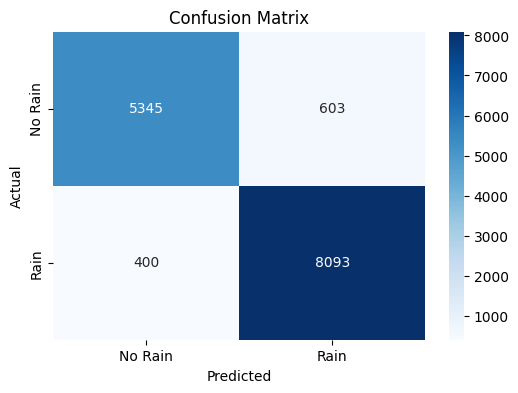

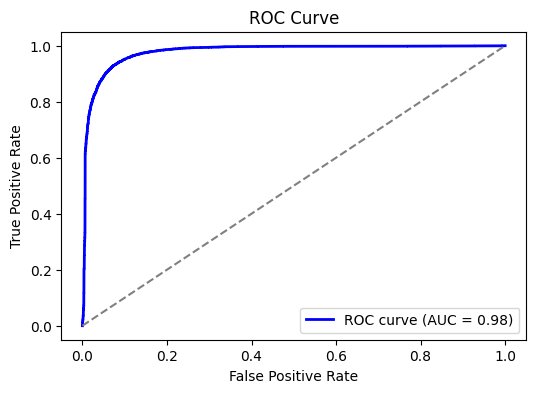

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, BatchNormalization, LeakyReLU
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.combine import SMOTEENN
from imblearn.metrics import geometric_mean_score
from sklearn.feature_selection import SelectKBest, f_classif
# Load dataset
df = pd.read_csv("/kaggle/input/weather-australia/weatherAUS.csv")
df.drop(['Date', 'Location'], axis=1, inplace=True)
df['RainToday'] = df['RainToday'].map({'No': 0, 'Yes': 1})
df['RainTomorrow'] = df['RainTomorrow'].map({'No': 0, 'Yes': 1})
# Encode categorical features
categorical_cols = ['WindGustDir', 'WindDir9am', 'WindDir3pm']
le = LabelEncoder()
for col in categorical_cols:
    df[col] = le.fit_transform(df[col].astype(str))
df.dropna(inplace=True)
# Features & Target
X = df.drop(['RainTomorrow'], axis=1)
y = df['RainTomorrow']
# Feature Selection (Increase to 15 features)
k = 20
selector = SelectKBest(score_func=f_classif, k=k)
X_selected = selector.fit_transform(X, y)
# Balance classes with SMOTE+ENN
smote_enn = SMOTEENN(random_state=42)
X_resampled, y_resampled = smote_enn.fit_resample(X_selected, y)
# Stratified K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
train_idx, test_idx = next(skf.split(X_resampled, y_resampled))
X_train, X_test = X_resampled[train_idx], X_resampled[test_idx]
y_train, y_test = y_resampled[train_idx], y_resampled[test_idx]
# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# Reshape for LSTM
X_train_LSTM = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_LSTM = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))
# Improved LSTM Model
lstm_model = Sequential([
    Bidirectional(LSTM(256, return_sequences=True, kernel_regularizer=l2(0.005))),
    BatchNormalization(),
    Dropout(0.3),

    Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer=l2(0.005))),
    BatchNormalization(),
    Dropout(0.3),

    Bidirectional(LSTM(64, return_sequences=False, kernel_regularizer=l2(0.005))),
    Dense(32, activation='relu', kernel_regularizer=l2(0.005)),
    Dropout(0.3),

    Dense(1, activation='sigmoid')
])
lstm_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy'])
# Improved ANN Model
ann_model = Sequential([
    Dense(256, kernel_regularizer=l2(0.005), input_shape=(X_train_scaled.shape[1],)),
    LeakyReLU(alpha=0.1),
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(128, kernel_regularizer=l2(0.005)),
    LeakyReLU(alpha=0.1),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, kernel_regularizer=l2(0.005)),
    LeakyReLU(alpha=0.1),
    BatchNormalization(),
    Dropout(0.3),

    Dense(1, activation='sigmoid')
])
ann_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy'])
# Callbacks
callbacks = [
    ReduceLROnPlateau(monitor='loss', factor=0.5, patience=3, verbose=1),
    EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
]
# Train LSTM
lstm_model.fit(X_train_LSTM, y_train, epochs=50, batch_size=64, verbose=1, callbacks=callbacks)
lstm_preds_train = lstm_model.predict(X_train_LSTM)
lstm_preds_test = lstm_model.predict(X_test_LSTM)
# Train ANN
ann_model.fit(X_train_scaled, y_train, epochs=50, batch_size=64, verbose=1, callbacks=callbacks)
ann_preds_train = ann_model.predict(X_train_scaled)
ann_preds_test = ann_model.predict(X_test_scaled)
# Stacking (SVM as Meta-Model)
X_meta_train = np.column_stack((lstm_preds_train, ann_preds_train))
X_meta_test = np.column_stack((lstm_preds_test, ann_preds_test))
meta_model = SVC(kernel='linear', probability=True)
meta_model.fit(X_meta_train, y_train)
# Get Final Predictions
meta_probs = meta_model.predict_proba(X_meta_test)[:, 1]
final_preds = (meta_probs > 0.5).astype(int)
# Evaluation
accuracy = accuracy_score(y_test, final_preds)
precision = precision_score(y_test, final_preds)
recall = recall_score(y_test, final_preds)
f1 = f1_score(y_test, final_preds)
g_mean = geometric_mean_score(y_test, final_preds)
print(f"✅ Accuracy: {accuracy:.4f}")
print(f"✅ Precision: {precision:.4f}")
print(f"✅ Recall: {recall:.4f}")
print(f"✅ F1-Score: {f1:.4f}")
print(f"✅ G-Mean: {g_mean:.4f}")
# Confusion Matrix
cm = confusion_matrix(y_test, final_preds)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['No Rain', 'Rain'], yticklabels=['No Rain', 'Rain'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, meta_probs)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()
